## Mathematical Principles in Pattern Recognition (2017/2018)
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bA}{\mathbf{A}}$
$\newcommand{\bQ}{\mathbf{Q}}$
$\newcommand{\bR}{\mathbf{R}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bSigma}{\boldsymbol{\Sigma}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bpi}{\boldsymbol{\pi}}$

# Lab 3

Micha de Groot, 10434410  
Jan Schutte, 11030844

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1 Maximum likelihood estimation
In this exercise, our goal is to use maximum likelihood estimation with gradient descent to estimate the probability density by using of a set of  samples drawn from a multivariate Gaussian. 

Note: even though there exists a close form solution for this case, we will go the academic route and use numerical optimization anyway.

### 1.1 Multivariate Gaussian
**[5 points]** Draw 250 samples from a multivariate Gaussian with parameters
$$
\bmu =
\begin{pmatrix}
        0.3 \\
        -1.8 \\
\end{pmatrix}\mathrm{;\ }
\bSigma =
\begin{pmatrix}
        2.1 & 1.3 \\
        1.3 & 4.9 \\
\end{pmatrix}\mathrm{;\ }
$$
and make a scatterplot of the result.

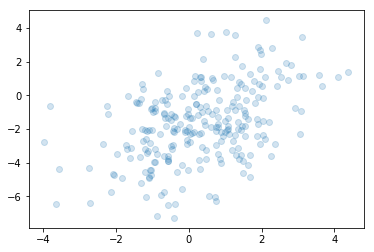

In [2]:
mu = array([0.3, -1.8])
sigma = array([[2.1, 1.3], [1.3, 4.9]])

data = multivariate_normal(mu, sigma, size=250)
# print(data)

plt.scatter(data[:, 0], data[:, 1], alpha=.2)

### 1.2 Log likelihood
**[15 points]** Write down the log likelihood of this two-dimensional Gaussian model and write a function `loglik(data, mu, sigma)` that returns the log likelihood for the data that it is given. (We will use this later.)

[your answer here]

In [3]:
def loglik(data, mu, sigma):
    result = log(1.0 / sqrt(2*pi ** len(mu)))
    result += log(1.0 / sqrt(det(sigma)))
    sigma_inv = inv(sigma)
    for i in range(len(data)):
        temp = -1.0/2.0*(data[i]-mu).T@sigma_inv@(data[i]-mu)
        result += temp
    return result


loglik(data, mu, sigma)

-249.17404247414078

### 1.3 Gradients
**[15 points]** Write down the gradient of the log likelihood with respect to $\boldsymbol{\mu}$, we already provided the gradient w.r.t. $\bSigma$ below:
$$
\nabla_{\bSigma} (\log \mathcal{L}) = - \frac{n}{2} \bSigma^{-1} + \frac{n}{2} \bSigma^{-1} \boldsymbol{S} \bSigma^{-1}\mathrm{,}
$$
where $\boldsymbol{S} = \frac{1}{n} \sum_i^n (\bx_i- \bmu)(\bx_i- \bmu)^T$. (if you like to derive it as an exercise, feel free to do so.)

Write a function `grad_loglik(x, mu, sigma)` that returns the gradients as evaluated on the data set `x`. 

[your answer here]

In [4]:
def grad_loglik(x, mu, sigma):
    grad_sigma = 0
    grad_mu = 0
    for vec in x:
        grad_mu += vec-mu
        grad_sigma += (vec-mu).reshape(2,1)@(vec-mu).reshape(1,2)
    grad_mu = -inv(sigma) @ grad_mu
    grad_sigma /= len(x)
    grad_sigma = -len(x)/2*inv(sigma) + len(x)/2*inv(sigma)@grad_sigma@inv(sigma)
    return (grad_mu, grad_sigma)

grad_loglik(data, mu, sigma)


(array([ 3.1332409 , -8.22792444]), array([[-3.66544637,  2.43372112],
        [ 2.43372112, -0.41293462]]))

### 1.4 Numerical optimization
**[35 points]** Numerically compute maximum likelihood estimates of all parameters. Implement the gradient ascent (or descent, https://en.wikipedia.org/wiki/Gradient_descent) numerical optimization method, by using the functions you created in 1.2 and 1.3. I.e. after initializing all parameters to reasonable values, repeat:
* calculate gradients for the data 
* update the parameters with the gradients and an appropriate learning rate

Keep track of the log likelihood after each step and make a plot of this. 
Run it for several iterations and visualize the resulting distribution with the data in the same figures (either 2 1D projections or a fancy 2D plot is accepted)

[ -9.79456627  14.97200843]
[[  5.62768563  -4.49165224]
 [ -4.49165224  10.98585693]]


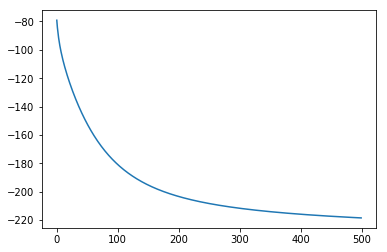

In [5]:
def gradient_decent(x, alpha=0.0001, iters=500):
    mu = np.zeros(2)
    sigma = np.identity(2)
    mu_plot = []
    for _ in range(iters):
        grad_mu, grad_sigma = grad_loglik(x, mu, sigma)
        mu = mu + alpha * grad_mu
        sigma = sigma + alpha * grad_sigma
        mu_plot.append(grad_mu)
#         print(grad_mu)
    print(mu)
    print(sigma)
    return array(mu_plot)

y = gradient_decent(data)
plt.plot(range(500), y[:, 0]);

## 2. Nonparametric density estimation
Up to now we have used parametric models for (density) estimation. One example of a nonparametric method we used earlier is the (normalized) histogram method, with fixed binning. We will explore an example of a  nonparametric method: kernel density estimation.

Consider the data loaded below, which is drawn from a mixture of 3 Gaussians.

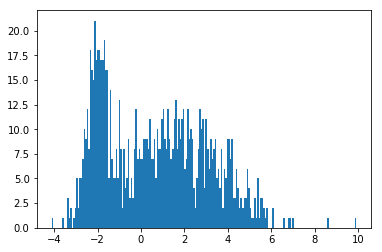

In [9]:
# We couldn't get cPickle to work on python3, so we converted 
# the data to npy format. It should be included with our submission.

mixed_data = np.load('mixture.npy')
plt.hist(mixed_data, 200);

### 2.1 Histograms

**[10 points]** Using the `mixed_data` above, illustrate two potential disadvantages of the histogram method as a nonparametric method for density estimation.

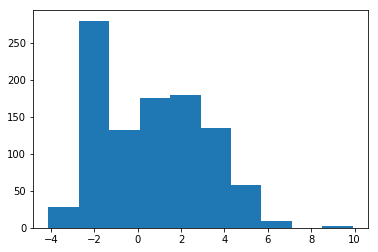

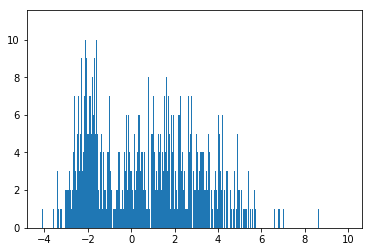

In [7]:
plt.hist(mixed_data, 10);
plt.show()
plt.hist(mixed_data, 500);

#### Knowing the bin size
From these two histograms we can see that choosing the right bin size is important for accuratly capturing the model. If the bins are too small, al lot of structure that doesn't exist is visible in the graph. Take the bins too big and you lose accuracy.

#### Dimensionality
The number of bins is dependent on the number of dimensions of the feature vector. This exponential growth may cause the number of bins be too large to incorporate into practical model.

### 2.2 Kernel density approximation
**[20 points]** One other way to estimate the density given some data sample, is by using kernels. A kernel $f_h(x)$ is a function of the data, given some smoothing parameter $h$, that specifies the local neighbourhood around a point. (See Bishop 2.5.2 or Hastie 2.8.2 or Google). 

Specify pros and cons of KDE over the histogram method by creating plots of the `mixed_data` above. Use in your arguments one or two different kernels with one or two different bandwidths. You are allowed to use a KDE code from whatever python package you prefer, for example `sklearn` or `statsmodels`.

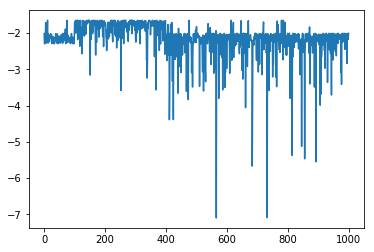

In [8]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(mixed_data.reshape(1000,1))
x = linspace(0, 10)
y = kde.score_samples(mixed_data.reshape(1000,1))
plt.plot(range(1000),y);

# Geen zin meer, sorry